In [1]:
from backtesting.test import SMA
import os
from binance.client import Client
import pandas as pd
import btalib
import numpy as np

In [2]:
# Binance API
api_key = os.environ.get('binance_api')
api_secret = os.environ.get('binance_secret')

In [3]:
client = Client(api_key, api_secret)

In [4]:
# from optparse import Values


def EMA(values, n):
    """
    Return exp moving average of `values`, at
    each step taking into account `n` previous values.
    """
    
    # return btalib.ema(Values, period=n)
    
    # return pd.Series(values).rolling(n).mean()
    return pd.Series(values).ewm(span=n, adjust=False).mean()


In [5]:
def SMA(values, n):
    """
    Return exp moving average of `values`, at
    each step taking into account `n` previous values.
    """
        
    return pd.Series(values).rolling(n).mean()
    

In [6]:
def bollinger_bands(df, length=20, m=2):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(length, min_periods=length).mean()), name='B_MA')
    sigma = data.rolling(length, min_periods=length).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [36]:
from backtesting import Strategy
from backtesting.lib import crossover


# we will use four moving averages in total: 
# two moving averages whose relationship determines a general trend (we only trade long when the shorter MA is above the longer one, and vice versa), 
# and two moving averages whose cross-over with daily close prices determine the signal to enter or exit the position.
class Sma4Cross(Strategy):
    n1 = 10 
    n2 = 28
    # n_enter = 20
    # n_exit = 10
    
    def init(self):
        # self.sma1 = self.I(EMA, self.data.Close, self.n1)
        # self.sma2 = self.I(EMA, self.data.Close, self.n2)
        
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                # if crossover(self.data.Close, self.sma_enter):
                self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            # else:
            #     if crossover(self.sma_enter, self.data.Close):
            #         self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            # if (self.position.is_long and
            #     crossover(self.sma_exit, self.data.Close)
            #     or
            #     self.position.is_short and
            #     crossover(self.data.Close, self.sma_exit)):
                
            self.position.close()

In [37]:
import datetime as dt

def getdata(Symbol):
    frame = pd.DataFrame(client.get_historical_klines(Symbol,
                                                      client.KLINE_INTERVAL_1DAY,
                                                    #   '3 years ago UTC')
                                                      '1 Feb, 2019 UTC',
                                                      # '26 Dec, 2021 UTC'
                                                      # '90 day ago UTC'
                                                      # '4000 hour ago UTC' # 4hour
                                                      ))
    
    frame = frame.iloc[:,:6] # use the first 5 columns
    frame.columns = ['Time','Open','High','Low','Close','Volume'] #rename columns
    frame[['Open','High','Low','Close','Volume']] = frame[['Open','High','Low','Close','Volume']].astype(float) #cast to float
    # frame.Time = pd.to_datetime(frame.Time, unit='ms') #make human readable timestamp
    frame.index = [dt.datetime.fromtimestamp(x/1000.0) for x in frame.Time]
    return frame

In [38]:
%%time 

from backtesting import Backtest

# GOOG = Open	High	Low	Close	Volume
df = getdata('SOLUSDT')
df = df.drop(['Time'], axis=1)
# df
# df = bollinger_bands(df)


bt = Backtest(df, Sma4Cross, cash=100000, commission=0)
stats = bt.run()
stats
# bt.plot() 


CPU times: user 417 ms, sys: 79.3 ms, total: 496 ms
Wall time: 2.3 s


Start                     2020-08-11 01:00:00
End                       2022-10-27 01:00:00
Duration                    807 days 00:00:00
Exposure Time [%]                   47.524752
Equity Final [$]                 9237511.8952
Equity Peak [$]                 11414201.2152
Return [%]                        9137.511895
Buy & Hold Return [%]              854.979536
Return (Ann.) [%]                  672.512329
Volatility (Ann.) [%]              698.111329
Sharpe Ratio                         0.963331
Sortino Ratio                       23.378842
Calmar Ratio                        26.917829
Max. Drawdown [%]                  -24.983899
Avg. Drawdown [%]                   -4.864939
Max. Drawdown Duration       97 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                  192
Win Rate [%]                        59.895833
Best Trade [%]                      46.300648
Worst Trade [%]                     -19.31934
Avg. Trade [%]                    

In [31]:
stats, heatmap = bt.optimize(
    n1=range(8, 50, 2),
    n2=range(8, 100, 2),
    # n_enter=range(15, 35, 5),
    # n_exit=range(10, 25, 5),
    # constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    # max_tries=200,
    # random_state=0,
    return_heatmap=True)

/home/joaosilva/.local/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 966 configurations.
  output = _optimize_grid()


In [32]:
heatmap.dropna(inplace=True)
heatmap.sort_values()

n1  n2
34  32    1.976731e+04
36  20    2.006246e+04
32  30    2.100795e+04
42  26    2.339233e+04
34  18    2.488479e+04
              ...     
24  30    5.999023e+06
22  40    6.041011e+06
12  50    7.730558e+06
26  32    8.169873e+06
10  28    9.237512e+06
Name: Equity Final [$], Length: 945, dtype: float64

In [13]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,8,10,12,14,16,18,20,22,24,26,...,80,82,84,86,88,90,92,94,96,98
n1,,,,,,,,,,,,,,,,,,,,,
8,NaN,9.617334e+05,2.979672e+05,471623.85386,165577.64530,4.360453e+05,111837.69452,866948.14531,1.727438e+05,219846.48015,...,7.650520e+04,6.225440e+04,9.553427e+04,1.450581e+05,2.713023e+05,2.004926e+05,2.124408e+05,2.867520e+05,2.330448e+05,3.200303e+05
10,2.547064e+05,NaN,1.779363e+05,315156.93913,196396.23304,3.874427e+05,246137.26061,166316.99340,8.894142e+04,106620.04013,...,1.748643e+05,1.235300e+05,1.350823e+05,1.913528e+05,2.750966e+05,2.282398e+05,3.543871e+05,2.463501e+05,1.356502e+05,8.981556e+04
12,2.195430e+05,2.363143e+05,NaN,273820.36360,251534.91837,1.146188e+05,91921.77167,82796.77787,1.644680e+05,440223.87959,...,3.131757e+05,3.511623e+05,4.484139e+05,2.641273e+05,2.015765e+05,2.048241e+05,1.413754e+05,1.618835e+05,4.167948e+05,4.845461e+05
14,1.063262e+05,3.011495e+05,7.254860e+05,NaN,82134.38928,8.625779e+04,279222.80071,797608.93880,2.251563e+05,283398.62061,...,2.337145e+05,1.193489e+05,4.017340e+05,5.173295e+05,9.025719e+05,5.908058e+05,2.534793e+05,1.839455e+05,1.823624e+05,1.475015e+05
16,2.423072e+05,5.497498e+05,6.396788e+05,134230.28372,NaN,3.103373e+05,839155.79085,392044.85211,3.389667e+05,208977.86909,...,2.583063e+05,6.425511e+05,5.245348e+05,3.453912e+05,1.656531e+05,1.298614e+05,3.284426e+05,1.419829e+05,1.777296e+05,1.421433e+05
18,2.796728e+05,9.467951e+05,3.587345e+05,352296.37007,233271.16648,NaN,293886.57792,368071.52782,8.595020e+04,73244.64473,...,5.257269e+05,2.569918e+05,3.030741e+05,4.955354e+05,2.135394e+05,5.820794e+05,4.185137e+05,3.938950e+05,7.516739e+05,6.023566e+05
20,1.346642e+06,5.034005e+05,2.330922e+05,302066.52718,97589.03293,2.794584e+05,NaN,77395.43843,1.105262e+05,474785.55091,...,3.692229e+05,1.915726e+05,2.633030e+05,8.512377e+05,4.687418e+05,9.078769e+05,7.758175e+05,3.015182e+05,6.137986e+05,4.321814e+05
22,2.344982e+06,2.287215e+05,1.852492e+05,64407.22749,245264.04269,2.008808e+05,191698.12681,NaN,5.243561e+05,644764.18867,...,8.248583e+05,4.849779e+05,8.839595e+05,5.145053e+05,8.193800e+05,3.971873e+05,3.003787e+05,7.043233e+05,6.099252e+05,3.736032e+05
24,7.067972e+05,2.633351e+05,1.498180e+05,227773.74797,88110.85362,1.714040e+05,146229.40218,39232.18537,NaN,306069.45969,...,8.336552e+05,9.664922e+05,1.353919e+06,4.960558e+05,4.243050e+05,3.998803e+05,7.977918e+05,8.138970e+05,1.043676e+06,5.066821e+05


<AxesSubplot:xlabel='n2', ylabel='n1'>

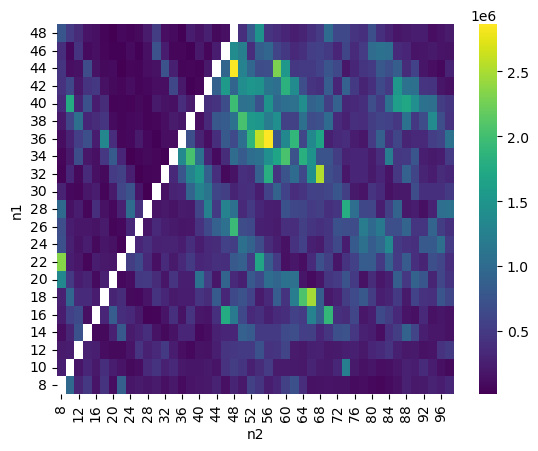

In [14]:
%matplotlib inline

import seaborn as sns


sns.heatmap(hm[::-1], cmap='viridis',vmin=1.537323e+04)

In [ ]:
import matplotlib.pyplot as plt

# GOOG = Open	High	Low	Close	Volume
coinPair = 'MATICUSDT'
df = getdata(coinPair)
df = df.drop(['Time'], axis=1)
df = bollinger_bands(df)

# df = bollinger_bands(df)
# df.plot(df.Close)
# df.plot.title('Price Close')
# plt.show()


In [ ]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'])
plt.title('Price chart (Adj Close) ' + str(coinPair))
plt.show()


In [ ]:

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(coinPair))
plt.plot(df.index, df['Close'])
plt.plot(df.index, df['BU'], alpha=0.3)
plt.plot(df.index, df['BL'], alpha=0.3)
plt.plot(df.index, df['B_MA'], alpha=0.3)
plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)

plt.show()